## All python Imports

In [1]:
# Normal Sci. Comp. Imports
import numpy as np
%matplotlib notebook
import matplotlib.pyplot as plt
# create random number generator for later/throughout
rng = np.random.default_rng(seed=120695)
# Load the keras data set module:
from tensorflow.keras.datasets import fashion_mnist
# import keras stuff
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

## Function for Prediction Stats

In [2]:
def mis_cls_stats(prds:np.array, truth:np.array):
    """ Identify some statistics about the misclassifications like what was mis classifided 
        how many times it was misclassifed, what was most often classified for incorrectly
        for it, etc.
        prds = predictions
        truth = true labels
    """
    class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
    # get number of sample/test
    M = truth.shape[0]
    # number of correct and wrong predictions
    num_r, num_w = np.sum(prds==truth), np.count_nonzero(prds-truth)
    print(f"The model gave {num_r} correct and {num_w} wrong predictions giving")
    print(f"an accuracy rate of {(num_r)/M} and an error rate of {(num_w)/M} \n")
    # first get the indices of the predictions matrix that were incorrect
    idx = np.nonzero(prds!=truth)[0]
    # now get all the labels that were miss classified and how many times so (counts_wrong)
    lbls, counts_w = np.unique(prds[idx], return_counts=True)
    # also get the correct number of labels and simplify the classes list
    counts_c = np.empty_like(counts_w)
    usd_cls = []
    for i in range(len(counts_w)):
        counts_c[i] = np.sum(truth == lbls[i])
        usd_cls.append(class_names[lbls[i]])
    # determine the individual class accuracies 
    cls_acc = 100*(1 - counts_w/counts_c)
    for i, l in enumerate(lbls):
        print(f"Label/class {class_names[l]} was miss labeled/classified {counts_w[i]} times")
        print(f"So approximately {100 *counts_w[i]/num_w:.2f}% of the misslabels were for {class_names[l]}")
        print(f"the accuracy rate for the {class_names[l]} alone was {cls_acc[i]:.2f}%\n")
        
    # plot horizonal bar char displaying misclassification per class
    fig1, ax1 = plt.subplots(figsize=(9,6))
    y_pos = np.arange(len(lbls))
    ax1.barh(y_pos, counts_w, align='center')
    ax1.set_yticks(y_pos, labels=usd_cls)
    ax1.set_xlabel('Miss Classifications')
    ax1.set_title(f'Num. Misclassifications For Model - Total = {num_w}')
    # Now create a verical bar chart for each class showing what was the miss classifications 
    # maximum of 20 sub figures and minimum of 2 (realistically going to have some misclassif.)
    num_cols = 2
    num_images = 2*len(lbls)
    num_rows = int(np.ceil(num_images/4))
    # plots is an example image of a label/class then its misclassification charts of what was 
    # predicted instead of it and some other things. Us two images per class and we want for 
    # images per row. 
    fig, ax = plt.subplots(num_rows, 2*num_cols, figsize=(2.5*2*num_cols, 2*num_rows))
    # tmp_img = np.empty((28,28), dtype=float)
    for i, l in enumerate(lbls):
        i_r, i_c = int(i/2), 0
        if i%2==1:
            i_c = 2
        # first display an image of the label
        jdx = np.nonzero(truth == l)[0][0]
        ax[i_r][i_c].set_xticks([])
        ax[i_r][i_c].set_yticks([])
        ax[i_r][i_c].imshow(x_test[jdx].reshape(28,28), cmap='gray')
        ax[i_r][i_c].set_xlabel(f"{class_names[l]}, {cls_acc[i]:.2f}% Acc.", fontsize=9)
        # now display bar chart of what was predicted instead
        ids = np.nonzero(prds[idx]==l)
        gues, g_counts = np.unique(truth[idx[ids]], return_counts=True)
        ax[i_r][i_c+1].bar(range(len(gues)), g_counts, align='center', color='red')
        ax[i_r][i_c+1].set_ylabel('Amount', fontsize=9)
        ax[i_r][i_c+1].set_xlabel('Wrong Predictions', fontsize=9)
        g_lbl = []
        for i in range(len(gues)):
            g_lbl.append(class_names[gues[i]])
        ax[i_r][i_c+1].set_xticks(range(len(gues)), g_lbl, fontsize=6.5, rotation=65)
        ax[i_r][i_c+1].set_title(f"{class_names[l]}, Misclassifications", fontsize=9)
        
    plt.tight_layout()
    plt.show()

## Data importing and then Normalization, etc

In [3]:
# with fashion mnist model data is already partitioned into training and validation
(X, Y), (x_test, y_test) = fashion_mnist.load_data()
x_train, x_valid = X[:48000], X[48000:]
y_train, y_valid = Y[:48000], Y[48000:]
# Reshape and Normalize the data
x_train = x_train.reshape(-1, 784)
x_valid = x_valid.reshape(-1, 784)
x_test = x_test.reshape(-1, 784)
norm_tr = x_train / 255
norm_va = x_valid / 255
norm_tst = x_test / 255
# Categorically encode the data (one-hot encoding)
num_categories = len(np.unique(y_train))
y_tr_encoded = keras.utils.to_categorical(y_train, num_categories)
y_va_encoded = keras.utils.to_categorical(y_valid, num_categories)
y_tst_encoded = keras.utils.to_categorical(y_test, num_categories)

## Data matrix and looping Variables

In [4]:
learning_rates = np.array([0.0001, 0.0003, 0.0005, 0.0007, 0.001, 0.003, 0.005, 0.007, 0.01, 0.013, 0.015, 0.017, 0.02, 0.025, 0.03, 0.07, 0.1, 0.2, 0.4])
g_data = np.empty(shape=(len(learning_rates),2))
out_data = np.empty(shape=(2*len(learning_rates),10))

## Loop to Create and Train the Model with 2 hidden layers only - Save data each pass

In [5]:
for i in range(len(learning_rates)):
    # create a new model in each time through the loop
    model2 = Sequential() 
    # input layer and first hidden layer
    model2.add(Dense(units=256, activation='relu', input_shape=(784,)))
    # second hidden layer
    model2.add(Dense(units=256, activation='relu',))
    # output layer
    model2.add(Dense(units=10, activation='softmax'))
    # now compile the models with the the correct loss, metrcs and optimzation method
    opt = keras.optimizers.Adam(learning_rate=learning_rates[i])
    model2.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=opt)
    history2 = model2.fit(
        x=norm_tr, y=y_tr_encoded, batch_size=32, epochs=10, verbose=1, validation_data=(norm_va, y_va_encoded)
    )
    # now trained save the validation and training accuracy results
    out_data[2*i] = history2.history['accuracy']
    out_data[2*i+1] = history2.history['val_accuracy']
    g_data[i, 0], g_data[i, 1] = history2.history['accuracy'][-1], history2.history['val_accuracy'][-1]
    if i != len(learning_rates)-1:
        del model2
    
out_data = out_data.T

Epoch 1/10
1500/1500 [==============================] - 4s 2ms/step - loss: 0.6271 - accuracy: 0.7907 - val_loss: 0.4602 - val_accuracy: 0.8322
Epoch 2/10
1500/1500 [==============================] - 4s 2ms/step - loss: 0.4221 - accuracy: 0.8518 - val_loss: 0.4063 - val_accuracy: 0.8564
Epoch 3/10
1500/1500 [==============================] - 4s 2ms/step - loss: 0.3803 - accuracy: 0.8657 - val_loss: 0.3781 - val_accuracy: 0.8641
Epoch 4/10
1500/1500 [==============================] - 4s 3ms/step - loss: 0.3521 - accuracy: 0.8755 - val_loss: 0.3676 - val_accuracy: 0.8694
Epoch 5/10
1500/1500 [==============================] - 4s 3ms/step - loss: 0.3333 - accuracy: 0.8807 - val_loss: 0.3539 - val_accuracy: 0.8762
Epoch 6/10
1500/1500 [==============================] - 4s 3ms/step - loss: 0.3164 - accuracy: 0.8859 - val_loss: 0.3417 - val_accuracy: 0.8767
Epoch 7/10
1500/1500 [==============================] - 4s 3ms/step - loss: 0.3028 - accuracy: 0.8900 - val_loss: 0.3452 - val_accuracy:

Epoch 8/10
1500/1500 [==============================] - 4s 3ms/step - loss: 0.2953 - accuracy: 0.8912 - val_loss: 0.3701 - val_accuracy: 0.8662
Epoch 9/10
1500/1500 [==============================] - 4s 3ms/step - loss: 0.2842 - accuracy: 0.8932 - val_loss: 0.4064 - val_accuracy: 0.8652
Epoch 10/10
1500/1500 [==============================] - 4s 2ms/step - loss: 0.2799 - accuracy: 0.8967 - val_loss: 0.3548 - val_accuracy: 0.8780
Epoch 1/10
1500/1500 [==============================] - 4s 3ms/step - loss: 0.5310 - accuracy: 0.8079 - val_loss: 0.4877 - val_accuracy: 0.8277
Epoch 2/10
1500/1500 [==============================] - 4s 2ms/step - loss: 0.4151 - accuracy: 0.8492 - val_loss: 0.4289 - val_accuracy: 0.8403
Epoch 3/10
1500/1500 [==============================] - 4s 2ms/step - loss: 0.3816 - accuracy: 0.8596 - val_loss: 0.4110 - val_accuracy: 0.8518
Epoch 4/10
1500/1500 [==============================] - 4s 2ms/step - loss: 0.3664 - accuracy: 0.8651 - val_loss: 0.3904 - val_accuracy

Epoch 5/10
1500/1500 [==============================] - 5s 4ms/step - loss: 0.4695 - accuracy: 0.8393 - val_loss: 0.4960 - val_accuracy: 0.8404
Epoch 6/10
1500/1500 [==============================] - 5s 3ms/step - loss: 0.4612 - accuracy: 0.8445 - val_loss: 0.4886 - val_accuracy: 0.8460
Epoch 7/10
1500/1500 [==============================] - 4s 3ms/step - loss: 0.4612 - accuracy: 0.8436 - val_loss: 0.4824 - val_accuracy: 0.8432
Epoch 8/10
1500/1500 [==============================] - 4s 3ms/step - loss: 0.4654 - accuracy: 0.8417 - val_loss: 0.5247 - val_accuracy: 0.8212
Epoch 9/10
1500/1500 [==============================] - 4s 3ms/step - loss: 0.4497 - accuracy: 0.8468 - val_loss: 0.5132 - val_accuracy: 0.8401
Epoch 10/10
1500/1500 [==============================] - 4s 3ms/step - loss: 0.4544 - accuracy: 0.8453 - val_loss: 0.4768 - val_accuracy: 0.8449
Epoch 1/10
1500/1500 [==============================] - 4s 3ms/step - loss: 0.6933 - accuracy: 0.7686 - val_loss: 0.6920 - val_accuracy

Epoch 2/10
1500/1500 [==============================] - 4s 3ms/step - loss: 2.3317 - accuracy: 0.0996 - val_loss: 2.3109 - val_accuracy: 0.1004
Epoch 3/10
1500/1500 [==============================] - 4s 3ms/step - loss: 2.3278 - accuracy: 0.0996 - val_loss: 2.3290 - val_accuracy: 0.1028
Epoch 4/10
1500/1500 [==============================] - 4s 3ms/step - loss: 2.3280 - accuracy: 0.1020 - val_loss: 2.3308 - val_accuracy: 0.1006
Epoch 5/10
1500/1500 [==============================] - 4s 3ms/step - loss: 2.3264 - accuracy: 0.1004 - val_loss: 2.3099 - val_accuracy: 0.0996
Epoch 6/10
1500/1500 [==============================] - 4s 3ms/step - loss: 2.3265 - accuracy: 0.1003 - val_loss: 2.3267 - val_accuracy: 0.1028
Epoch 7/10
1500/1500 [==============================] - 4s 3ms/step - loss: 2.3284 - accuracy: 0.1008 - val_loss: 2.3077 - val_accuracy: 0.0984
Epoch 8/10
1500/1500 [==============================] - 4s 3ms/step - loss: 2.3275 - accuracy: 0.1003 - val_loss: 2.3288 - val_accuracy:

## Save the training and validation accuracies over each epoch to txt file 

In [6]:
np.savetxt(fname='TF_datasets/FFNN_VarLearnRates_Acc_data.txt', X=out_data, header='(0.0001) Tr Acc, - (0001) Val Acc. - (0.0003) Tr Acc. - (0.0003) Val Acc. - ...')

## Make some predictions

The model gave 1003 correct and 8997 wrong predictions giving
an accuracy rate of 0.1003 and an error rate of 0.8997 

Label/class Ankle boot was miss labeled/classified 8997 times
So approximately 100.00% of the misslabels were for Ankle boot
the accuracy rate for the Ankle boot alone was -799.70%



<IPython.core.display.Javascript object>


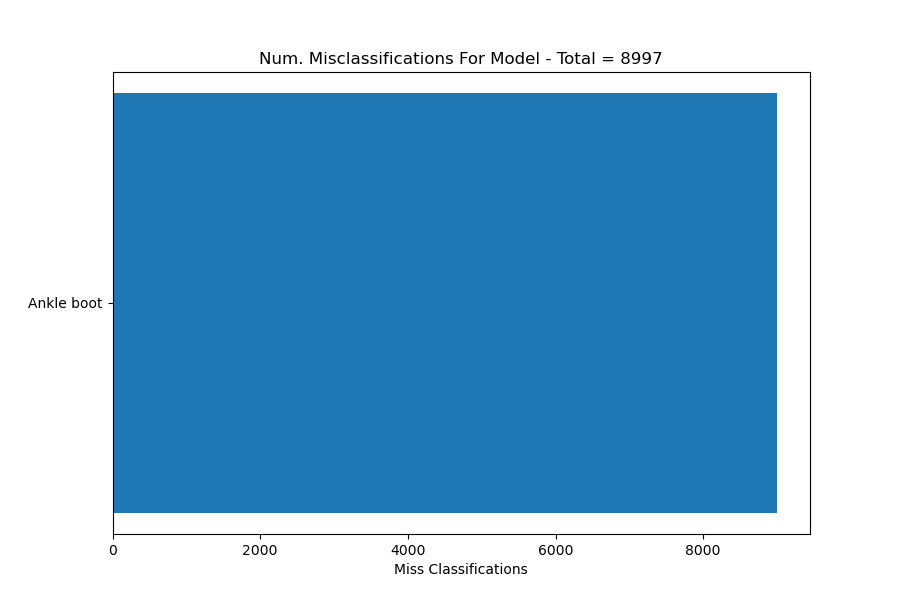

<IPython.core.display.Javascript object>


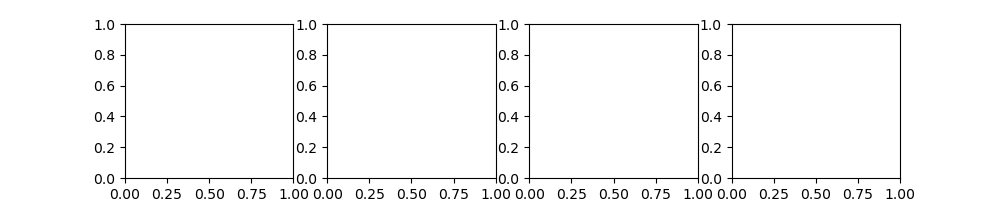

TypeError: 'AxesSubplot' object is not subscriptable

In [7]:
p2 = model2.predict(x=norm_tst)
preds2 = np.argmax(p2, axis=1)
mis_cls_stats(preds2, y_test)

## Extra:
A separate notebook takes the data saved above to create a plot of the training and validation accuracy from one epoch to the next but if you want to display it here and save it to the current working directory copy and past the following lines of python code into a code cell and run it.
```Python
fig = plt.figure()
plt.semilogx(learning_rates, g_data[:, 0]*100, 'k.--', learning_rates, g_data[:, 1]*100, 'b.--', markersize=16)
plt.xlabel('Learning Rate', fontsize=16)
plt.ylabel('% Accuracy', fontsize=16)
plt.legend(['Train', 'Validation'], fontsize=16)
plt.show()
plt.savefig(fname='Vary_LearningRates.png', format='png')
```

In [ ]:
learning_rates

In [9]:
np.unique(preds2)

array([5, 9], dtype=int64)